In [ ]:
"""
Purpose:

Recieves: 
1) Mesh object
2) List of faces for facet1 and facet2

Returns:
1) Mesh object
-> with the original facet faces deleted

"""

In [1]:
import trimesh
import numpy as np
from collections import Counter
import time
import math
from tqdm import tqdm

In [2]:
gap_mesh = trimesh.load_mesh("./test_meshes/example_gap_mesh.off")

In [3]:
gap_mesh.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [9]:
# need a way of finding the neighbors that have to share adjacent faces
def create_neighbors_lookup(mesh):
    start_time = time.time()
    neighbors_lookup = dict([(i,[]) for i in range(0,len(mesh.faces))])
    print(f"Creating empty dictionary : {time.time() - start_time}")
    
    start_time = time.time()
    for adj in mesh.face_adjacency:
        neighbors_lookup[adj[0]].append(adj[1])
        neighbors_lookup[adj[1]].append(adj[0])
    print(f"Filling in neighbors lookup : {time.time() - start_time}")
    
    return neighbors_lookup

In [14]:
#get all of the neighbors as well and apply filtering effects
def filter_and_expand_facets(new_mesh,
                             first_pass_size_threshold=2000,
                             normal_closeness=0.985):
    
    
    #filter the facets that are below a size threshold
    new_facets = new_mesh.facets[np.where(new_mesh.facets_area > first_pass_size_threshold)[0]]

    neighbors_lookup = create_neighbors_lookup(new_mesh)
    
    #generate a normals lookup table and see if works faster than regular lookup
    normal_lookup = {}

    for i in range(0,len(new_mesh.faces)):
        normal_lookup[i] = new_mesh.face_normals[i]
    
    global_start_time = time.time()
    final_facets= [0]*len(new_facets)
    
    for i,facet in enumerate(new_facets):
    #     mini_global_start_time = time.time()
    #     print(facet)
    #     print(type(facet))
    #     start_time = time.time()
    #     print([find_neighbors(k) for k in facet])
        total_neighbors = list(set(np.hstack([neighbors_lookup[k] for k in facet])).difference(set(facet)))
    #     print(total_neighbors)
    #     print(f"time initial neighbors: {(time.time() - start_time)}")
        neighbors_to_add = []
        neighbors_checked = []
        #print(total_neighbors)

        #just get the normal from one of the faces already in the facet
    #     start_time = time.time()
        facet_normal = normal_lookup[facet[0]]

    #     total_dot_time = 0
        while len(total_neighbors) > 0:
            current_neighbor = total_neighbors.pop()
            neighbors_checked.append(current_neighbor)

    #         print("--------------")
    # #         #check to see if neighbor has same normal face
    # #         start_dot_time = time.time()
    # #         dot_result = np.dot(new_mesh.face_normals[current_neighbor],facet_normal) #> normal_closeness
    # #         print(dot_result)
    # #         print((time.time() - start_dot_time) * 1000)

    #         start_dot_time = time.time()
    #         print(current_neighbor)
    #         #a = new_mesh.face_normals[current_neighbor]

    #         print((time.time() - start_dot_time) * 1000)
    #         dot_result = a[0]*facet_normal[0] + a[1]*facet_normal[1] + a[2]*facet_normal[2]  > normal_closeness
    #         print(dot_result)
    #         print((time.time() - start_dot_time) * 1000)
    #         print("--------------")

    #         total_dot_time += (time.time() - start_dot_time)*1000

            a = normal_lookup[current_neighbor]
            if a[0]*facet_normal[0] + a[1]*facet_normal[1] + a[2]*facet_normal[2]  > normal_closeness:

                neighbors_to_add.append(current_neighbor)
                #get the neighbors of this current face
                for neigh in neighbors_lookup[current_neighbor]:
                    #only add those neighbors that havent already been checked, in original facet group, or already in list to check
                    if neigh not in neighbors_checked and neigh not in facet and neigh not in total_neighbors:
                        total_neighbors.append(neigh)
    #     print(f"Total dot time: {total_dot_time}")
    #     print(f"time loop: {(time.time() - start_time)}")
    #     print("neighbors_to_add = " + str(neighbors_to_add))abs
    #     print("neighbors_checked = " + str(neighbors_checked))
    #     print("adding list = " + str(list(facet) + neighbors_to_add))
    #     start_time = time.time()
        final_facets[i] = list(facet) + neighbors_to_add
    #     print(f"Appending to list: {(time.time() - start_time)}")

    #     print(f"Total time: {(time.time() - mini_global_start_time)}")
    #     print("------------------------------------------------------")


    print(f"Total Facet building time: {(time.time() - global_start_time)}")
    return final_facets




In [16]:
#get the filtered facets
final_facets = filter_and_expand_facets(gap_mesh,
                             first_pass_size_threshold=2000,
                             normal_closeness=0.985)

# download the facets list and see if the process worked:
facets_group = np.zeros(len(gap_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets):
    for face in facet_group:
        facets_group[face] = i + 1 #so that you reserve the label 0 for blenders none

np.savez("./convex_stats/gap_mesh.npz",facets_group=facets_group)

""" Conclusion:
They look good so far,
now see if can filter them by size

"""

Creating empty dictionary : 0.007515430450439453
Filling in neighbors lookup : 0.04560995101928711
Total Facet building time: 0.14191246032714844


' Conclusion:\nThey look good so far,\nnow see if can filter them by size\n\n'

In [18]:
#The two biggest facet groups that need to be stitched together have following fcces
[1784,7097]

facet_1 = []
facet_2 = []

for f in final_facets:
    if 1784 in f:
        facet_1 = f
    if 7097 in f:
        facet_2 = f

In [20]:
len(facet_1),len(facet_2)

(227, 55)

In [104]:
import trimesh
import numpy as np
from collections import Counter
import time
import math

#gets the projection of point p onto line a
def ClosestPointOnLine(a, b, p):
    ap = p-a
    ab = b-a
    #base_vector = ab
    result = np.dot(ap,ab)/np.dot(ab,ab) # * ab
    return result

# #now have the mesh and the facet faces, can send to function
def stitch_mesh_piece(new_mesh,facet_1,facet_2):
    #how to find the normals of facet groups:
    facet_group_1_normal = new_mesh.face_normals[facet_1[0]]
    facet_group_2_normal = new_mesh.face_normals[facet_2[0]]


    #get the correct version of the normals:
    if np.dot(facet_group_1_normal,facet_group_2_normal) > 0.8:
        pass
    elif np.dot(facet_group_1_normal,facet_group_2_normal) < -0.8:
        print("opposite normals")
        facet_group_2_normal = facet_group_2_normal*-1
    else:
        raise Exception("Not correct normals")

    print(facet_group_1_normal,facet_group_2_normal)

    # make each row correspond to a single face
    edges = new_mesh.edges_sorted.reshape((-1, 6))
    # get the edges for each facet
    edges_facet = [edges[i].reshape((-1, 2)) for i in [facet_1,facet_2]]
    edges_boundary = np.array([i[trimesh.grouping.group_rows(i, require_count=1)]
                               for i in edges_facet])

    edge_0 = edges_boundary[0]
    edge_1 = edges_boundary[1]

    #gets the unique number of points
    edge_0_points = np.unique(np.hstack(edge_0))
    edge_1_points = np.unique(np.hstack(edge_1))

    """
    get the dot product of all the points
    """

    #get any 2 points on the triangle and make that the reference traingle
    edge_0_anchor_points = new_mesh.vertices[[edge_0_points[0],edge_0_points[1]]]

    #gets the starting index for the 1st facet
    max_index = edge_0_points[0]
    max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

    for i in range(1,len(edge_0_points)):
        current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_0_points[i]])

        if current_magnitude > max_magnitude:
            max_index = i
            max_magnitude = current_magnitude

    edge_0_starting_point = edge_0_points[max_index]

    #gets the starting index for the 2nd facet
    max_index = edge_1_points[0]
    max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

    for i in range(1,len(edge_1_points)):
        current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_1_points[i]])
        if current_magnitude > max_magnitude:
            max_index = i
            max_magnitude = current_magnitude

    edge_1_starting_point = edge_1_points[max_index]

    print(f"starting edge 1st facet = {edge_0_starting_point}, starting edge 2nd facet= {edge_1_starting_point}, ")
    print(new_mesh.vertices[edge_0_starting_point],new_mesh.vertices[edge_1_starting_point])

    """
    Need to order the points for restitching

    Pseudocode: 
    1) Get starting piont
    2) Find the two edges corresponding to that point
    3) Need to decide which direction to start....
    - go in direction that make the cross of the (1st and last) point in the same direction of the 
    normal of the first facet
    4) loop through and record the orders of the vertices as you traverse along the edges 
    until you arrive back at the start
    5) Error if:
        a. You arrive back at the start and haven't processed all the edges
        b. Processsed all the edges but haven't arrived back at start

    6) Repeat steps 1 through 5 for 2nd facet group
    """
    start_point_list = [edge_0_starting_point,edge_1_starting_point]
    edge_list = [edge_0,edge_1]
    edge_order_list = []


    for i,start_point in enumerate(start_point_list):
        print(f"start_point = {start_point}")
        edge_order = [start_point]
        processed_edges = []

        #find the matching edges
        starting_edges_indices = np.where(np.logical_or(edge_list[i][:,0] == start_point,edge_list[i][:,1] == start_point) == True)[0]
        #print(starting_edges_indices)
        starting_edges = edge_list[i][starting_edges_indices]
        #print(f"starting edges = {starting_edges}")

        if starting_edges.size < 4:
            raise Exception("Not enough edges for 1st facet start point")

        if starting_edges.size > 4:
            raise Exception("Too many edges for 1st facet start point") 

        #np.where(starting_edges[1,:] != start_point)[0][0]
        possible_starting_vector_1 = new_mesh.vertices[np.where(starting_edges[0,:] != start_point)[0][0]] - new_mesh.vertices[start_point]
        possible_starting_vector_2 = new_mesh.vertices[np.where(starting_edges[1,:] != start_point)[0][0]] - new_mesh.vertices[start_point]

        #find the cross product of the starting vectors
        starting_edges_cross = np.cross(possible_starting_vector_1,possible_starting_vector_2)

        #make sure that the order of the vectors goes so that the cross product is in line with the starting normal
        if np.dot(starting_edges_cross,facet_group_1_normal) > 0:
            #print("group 1 picked")
            processed_edges.append(starting_edges_indices[0])
            current_vertex = starting_edges[0][np.where(starting_edges[0,:] != start_point)[0][0]]
        else:
            #print("group 2 picked")
            processed_edges.append(starting_edges_indices[1])
            #print("np.where(starting_edges[1,:] != start_point) = " + str(np.where(starting_edges[1,:] != start_point)))
            current_vertex = starting_edges[1][np.where(starting_edges[1,:] != start_point)[0][0]]

        #print(f"current_vertex = {current_vertex}" )

        #now iterate through number of 
        for z in range(1,edge_list[i][:,0].size):
            if current_vertex == start_point:
                raise Exception("Start vertex reached before processed all of edges")

            #get the next edge
            counter = 0
            next_vertex = -1
            for j,edg in enumerate(edge_list[i]):
                #print("edg = " + str(edg))
                #print("processed_edges = " + str(processed_edges))
                if current_vertex in edg and j not in processed_edges:
                    current_edge_index = j
                    if edg[0] != current_vertex:
                        next_vertex = edg[0]
                    else:
                        next_vertex = edg[1]


                    counter += 1
                    if counter >= 2:
                        raise Exception(f"More than 2 edges possibilities for {current_vertex}")

            #make sure the next vertex was found
            if next_vertex <= -1:
                raise Exception(f"No next vertex was found for {current_vertex} ")

            #if found next vertex
            processed_edges.append(current_edge_index)
            edge_order.append(current_vertex)

            current_vertex = next_vertex


        edge_order_list.append(edge_order)
        print(f"edge_{i}_order = {edge_order}")

    lengths_of_boundaries = [len(x) for x in edge_order_list]
    bigger = lengths_of_boundaries.index(max(lengths_of_boundaries))
    smaller = 1-bigger

    print(f"index of bigger facets = {bigger}\nindex of smaller facets = {smaller}",)

    dividend = int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])
    remainder = lengths_of_boundaries[bigger] - int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])*lengths_of_boundaries[smaller]

    print(f"dividend = {dividend}, remainder = {remainder}")


    new_faces = []
    current_bigger = 0
    for i,current_smaller in enumerate(edge_order_list[smaller]):
        print("current_smaller =" + str(current_smaller))
        print("current_bigger=" + str(current_bigger))
        if i == 0:
            new_faces.append([current_smaller,edge_order_list[smaller][-1],edge_order_list[bigger][current_bigger]])
        else:
            new_faces.append([current_smaller,edge_order_list[smaller][i-1],edge_order_list[bigger][current_bigger]])

        for j in range(0,dividend + int(i<remainder)):
            if current_bigger > len(edge_order_list[bigger]):
                raise Exception("Somehow rapped around too much")

            if current_bigger >= len(edge_order_list[bigger])-1:
                next_bigger = 0
            else:
                next_bigger = current_bigger+1

            new_faces.append([current_smaller,edge_order_list[bigger][current_bigger],
                                edge_order_list[bigger][next_bigger]])

            current_bigger += 1

    print("new_faces = " + str(new_faces))

    stitch_mesh = trimesh.Trimesh()

    stitch_mesh.vertices = new_mesh.vertices
    stitch_mesh.faces = new_mesh.faces
    stitch_mesh.faces = np.vstack([stitch_mesh.faces, new_faces])
    
    added_mesh = trimesh.Trimesh()
    added_mesh.vertices = new_mesh.vertices
    added_mesh.faces = new_faces

    trimesh.repair.fix_inversion(stitch_mesh)
    trimesh.repair.fix_winding(stitch_mesh)
    trimesh.repair.fix_normals(stitch_mesh)
    
    trimesh.repair.fix_inversion(added_mesh)
    trimesh.repair.fix_winding(added_mesh)
    trimesh.repair.fix_normals(added_mesh)

    
    return stitch_mesh,added_mesh







    

In [88]:
stitch_mesh = stitch_mesh_piece(new_mesh=gap_mesh,facet_1=facet_1,facet_2=facet_2)

opposite normals
[-0.09544989  0.99543424  0.        ] [-1.32776239e-04  9.99934429e-01 -1.14507979e-02]
starting edge 1st facet = 10013, starting edge 2nd facet= 10282, 
[ 425443.6875       11419.42480469 -170083.234375  ] [ 425632.71875     11544.3828125 -170136.34375  ]
start_point = 10013
edge_0_order = [10013, 5856, 13026, 10375, 7230, 7132, 8624, 9994, 166, 164, 162, 161, 160, 159, 158, 157, 167, 165, 5165, 5633, 4930, 8652, 5660, 11751, 4242, 5768, 10702, 1863, 9376, 12026]
start_point = 10282
edge_1_order = [10282, 5352, 6922, 12090, 6430, 12702, 10064, 3217, 9555, 7653, 12325, 11307, 9845, 6355, 3183, 12157, 12612, 12049, 4906, 9478, 12392, 5327, 624, 10555, 8548, 3209, 11383, 9609, 11908, 625, 2917, 12256, 4604, 3264, 9380, 11334]
index of bigger facets = 1
index of smaller facets = 0
dividend = 1, remainder = 6
current_smaller =10013
current_bigger=0
current_smaller =5856
current_bigger=2
current_smaller =13026
current_bigger=4
current_smaller =10375
current_bigger=6
current

# Do some other mesh examples to make sure it works

In [105]:
"""
Step 1: Get facets

"""
file_location = "./test_meshes/"
file_name ="example_neuron_gap_2.off"
gap_mesh = trimesh.load_mesh(file_location + file_name)
#get the filtered facets
final_facets = filter_and_expand_facets(gap_mesh,
                             first_pass_size_threshold=2000,
                             normal_closeness=0.985)

# download the facets list and see if the process worked:
facets_group = np.zeros(len(gap_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets):
    for face in facet_group:
        facets_group[face] = i + 1 #so that you reserve the label 0 for blenders none

np.savez("./test_meshes/" + file_name[:-4] + "_facets.npz",facets_group=facets_group)

Creating empty dictionary : 0.009194374084472656
Filling in neighbors lookup : 0.061280012130737305
Total Facet building time: 0.15114188194274902


In [106]:
"""
Step 2: Manually import the facets to check 
and get the indexes of faces on the two different facet groups

"""
manual_retrieved_indexes= [12684,23626]

In [107]:
"""
Step 3: Get a list of the facets groups based on the 
manually retrieved indexes

"""

#The two biggest facet groups that need to be stitched together have following fcces
[1784,7097]

facet_1 = []
facet_2 = []

for f in final_facets:
    if manual_retrieved_indexes[0] in f:
        facet_1 = f
    if manual_retrieved_indexes[1] in f:
        facet_2 = f

print(len(facet_1),len(facet_2))

28 68


In [108]:
gap_mesh.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [109]:
"""
Step 4: Running the stitching method


"""
stitch_mesh,added_mesh = stitch_mesh_piece(new_mesh=gap_mesh,facet_1=facet_1,facet_2=facet_2)

opposite normals
[-0.09544989  0.99543424  0.        ] [-1.32776239e-04  9.99934429e-01 -1.14507979e-02]
starting edge 1st facet = 10013, starting edge 2nd facet= 10282, 
[ 425443.6875       11419.42480469 -170083.234375  ] [ 425632.71875     11544.3828125 -170136.34375  ]
start_point = 10013
edge_0_order = [10013, 5856, 13026, 10375, 7230, 7132, 8624, 9994, 166, 164, 162, 161, 160, 159, 158, 157, 167, 165, 5165, 5633, 4930, 8652, 5660, 11751, 4242, 5768, 10702, 1863, 9376, 12026]
start_point = 10282
edge_1_order = [10282, 5352, 6922, 12090, 6430, 12702, 10064, 3217, 9555, 7653, 12325, 11307, 9845, 6355, 3183, 12157, 12612, 12049, 4906, 9478, 12392, 5327, 624, 10555, 8548, 3209, 11383, 9609, 11908, 625, 2917, 12256, 4604, 3264, 9380, 11334]
index of bigger facets = 1
index of smaller facets = 0
dividend = 1, remainder = 6
current_smaller =10013
current_bigger=0
current_smaller =5856
current_bigger=2
current_smaller =13026
current_bigger=4
current_smaller =10375
current_bigger=6
current

In [111]:
print_trimesh(added_mesh,"./test_meshes/added_mesh.off")

In [95]:
stitch_mesh.show()

TypeError: show() takes 1 positional argument but 2 were given

In [96]:
print_trimesh(stitch_mesh,"example_neuron_gap_2_fixed_1.off")

# Testing the stitching being off with the starting offs

In [113]:
new_mesh=gap_mesh
facet_1=facet_1
facet_2=facet_2


In [114]:
import trimesh
import numpy as np
from collections import Counter
import time
import math

#gets the projection of point p onto line a
def ClosestPointOnLine(a, b, p):
    ap = p-a
    ab = b-a
    #base_vector = ab
    result = np.dot(ap,ab)/np.dot(ab,ab) # * ab
    return result


#how to find the normals of facet groups:
facet_group_1_normal = new_mesh.face_normals[facet_1[0]]
facet_group_2_normal = new_mesh.face_normals[facet_2[0]]


#get the correct version of the normals:
if np.dot(facet_group_1_normal,facet_group_2_normal) > 0.8:
    pass
elif np.dot(facet_group_1_normal,facet_group_2_normal) < -0.8:
    print("opposite normals")
    facet_group_2_normal = facet_group_2_normal*-1
else:
    raise Exception("Not correct normals")

print(facet_group_1_normal,facet_group_2_normal)

# make each row correspond to a single face
edges = new_mesh.edges_sorted.reshape((-1, 6))
# get the edges for each facet
edges_facet = [edges[i].reshape((-1, 2)) for i in [facet_1,facet_2]]
edges_boundary = np.array([i[trimesh.grouping.group_rows(i, require_count=1)]
                           for i in edges_facet])

edge_0 = edges_boundary[0]
edge_1 = edges_boundary[1]

#gets the unique number of points
edge_0_points = np.unique(np.hstack(edge_0))
edge_1_points = np.unique(np.hstack(edge_1))

"""
get the dot product of all the points
"""

#get any 2 points on the triangle and make that the reference traingle
edge_0_anchor_points = new_mesh.vertices[[edge_0_points[0],edge_0_points[1]]]

#gets the starting index for the 1st facet
max_index = edge_0_points[0]
max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

for i in range(1,len(edge_0_points)):
    current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_0_points[i]])

    if current_magnitude > max_magnitude:
        max_index = i
        max_magnitude = current_magnitude

edge_0_starting_point = edge_0_points[max_index]

#gets the starting index for the 2nd facet
max_index = edge_1_points[0]
max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

for i in range(1,len(edge_1_points)):
    current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_1_points[i]])
    if current_magnitude > max_magnitude:
        max_index = i
        max_magnitude = current_magnitude

edge_1_starting_point = edge_1_points[max_index]

print(f"starting edge 1st facet = {edge_0_starting_point}, starting edge 2nd facet= {edge_1_starting_point}, ")
print(new_mesh.vertices[edge_0_starting_point],new_mesh.vertices[edge_1_starting_point])

"""
Need to order the points for restitching

Pseudocode: 
1) Get starting piont
2) Find the two edges corresponding to that point
3) Need to decide which direction to start....
- go in direction that make the cross of the (1st and last) point in the same direction of the 
normal of the first facet
4) loop through and record the orders of the vertices as you traverse along the edges 
until you arrive back at the start
5) Error if:
    a. You arrive back at the start and haven't processed all the edges
    b. Processsed all the edges but haven't arrived back at start

6) Repeat steps 1 through 5 for 2nd facet group
"""
start_point_list = [edge_0_starting_point,edge_1_starting_point]
edge_list = [edge_0,edge_1]
edge_order_list = []


for i,start_point in enumerate(start_point_list):
    print(f"start_point = {start_point}")
    edge_order = [start_point]
    processed_edges = []

    #find the matching edges
    starting_edges_indices = np.where(np.logical_or(edge_list[i][:,0] == start_point,edge_list[i][:,1] == start_point) == True)[0]
    #print(starting_edges_indices)
    starting_edges = edge_list[i][starting_edges_indices]
    #print(f"starting edges = {starting_edges}")

    if starting_edges.size < 4:
        raise Exception("Not enough edges for 1st facet start point")

    if starting_edges.size > 4:
        raise Exception("Too many edges for 1st facet start point") 

    #np.where(starting_edges[1,:] != start_point)[0][0]
    possible_starting_vector_1 = new_mesh.vertices[np.where(starting_edges[0,:] != start_point)[0][0]] - new_mesh.vertices[start_point]
    possible_starting_vector_2 = new_mesh.vertices[np.where(starting_edges[1,:] != start_point)[0][0]] - new_mesh.vertices[start_point]

    #find the cross product of the starting vectors
    starting_edges_cross = np.cross(possible_starting_vector_1,possible_starting_vector_2)

    #make sure that the order of the vectors goes so that the cross product is in line with the starting normal
    if np.dot(starting_edges_cross,facet_group_1_normal) > 0:
        #print("group 1 picked")
        processed_edges.append(starting_edges_indices[0])
        current_vertex = starting_edges[0][np.where(starting_edges[0,:] != start_point)[0][0]]
    else:
        #print("group 2 picked")
        processed_edges.append(starting_edges_indices[1])
        #print("np.where(starting_edges[1,:] != start_point) = " + str(np.where(starting_edges[1,:] != start_point)))
        current_vertex = starting_edges[1][np.where(starting_edges[1,:] != start_point)[0][0]]

    #print(f"current_vertex = {current_vertex}" )

    #now iterate through number of 
    for z in range(1,edge_list[i][:,0].size):
        if current_vertex == start_point:
            raise Exception("Start vertex reached before processed all of edges")

        #get the next edge
        counter = 0
        next_vertex = -1
        for j,edg in enumerate(edge_list[i]):
            #print("edg = " + str(edg))
            #print("processed_edges = " + str(processed_edges))
            if current_vertex in edg and j not in processed_edges:
                current_edge_index = j
                if edg[0] != current_vertex:
                    next_vertex = edg[0]
                else:
                    next_vertex = edg[1]


                counter += 1
                if counter >= 2:
                    raise Exception(f"More than 2 edges possibilities for {current_vertex}")

        #make sure the next vertex was found
        if next_vertex <= -1:
            raise Exception(f"No next vertex was found for {current_vertex} ")

        #if found next vertex
        processed_edges.append(current_edge_index)
        edge_order.append(current_vertex)

        current_vertex = next_vertex


    edge_order_list.append(edge_order)
    print(f"edge_{i}_order = {edge_order}")

lengths_of_boundaries = [len(x) for x in edge_order_list]
bigger = lengths_of_boundaries.index(max(lengths_of_boundaries))
smaller = 1-bigger

print(f"index of bigger facets = {bigger}\nindex of smaller facets = {smaller}",)

dividend = int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])
remainder = lengths_of_boundaries[bigger] - int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])*lengths_of_boundaries[smaller]

print(f"dividend = {dividend}, remainder = {remainder}")


new_faces = []
current_bigger = 0
for i,current_smaller in enumerate(edge_order_list[smaller]):
    print("current_smaller =" + str(current_smaller))
    print("current_bigger=" + str(current_bigger))
    if i == 0:
        new_faces.append([current_smaller,edge_order_list[smaller][-1],edge_order_list[bigger][current_bigger]])
    else:
        new_faces.append([current_smaller,edge_order_list[smaller][i-1],edge_order_list[bigger][current_bigger]])

    for j in range(0,dividend + int(i<remainder)):
        if current_bigger > len(edge_order_list[bigger]):
            raise Exception("Somehow rapped around too much")

        if current_bigger >= len(edge_order_list[bigger])-1:
            next_bigger = 0
        else:
            next_bigger = current_bigger+1

        new_faces.append([current_smaller,edge_order_list[bigger][current_bigger],
                            edge_order_list[bigger][next_bigger]])

        current_bigger += 1

print("new_faces = " + str(new_faces))

stitch_mesh = trimesh.Trimesh()

stitch_mesh.vertices = new_mesh.vertices
stitch_mesh.faces = new_mesh.faces
stitch_mesh.faces = np.vstack([stitch_mesh.faces, new_faces])

added_mesh = trimesh.Trimesh()
added_mesh.vertices = new_mesh.vertices
added_mesh.faces = new_faces

trimesh.repair.fix_inversion(stitch_mesh)
trimesh.repair.fix_winding(stitch_mesh)
trimesh.repair.fix_normals(stitch_mesh)

trimesh.repair.fix_inversion(added_mesh)
trimesh.repair.fix_winding(added_mesh)
trimesh.repair.fix_normals(added_mesh)








opposite normals
[-0.09544989  0.99543424  0.        ] [-1.32776239e-04  9.99934429e-01 -1.14507979e-02]
starting edge 1st facet = 10013, starting edge 2nd facet= 10282, 
[ 425443.6875       11419.42480469 -170083.234375  ] [ 425632.71875     11544.3828125 -170136.34375  ]


In [123]:
facet_1_mesh = new_mesh.submesh([facet_1])[0]
facet_2_mesh = new_mesh.submesh([facet_2])[0]

facets_together = facet_1_mesh + facet_2_mesh
facets_together 

facets_together.show()


/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [126]:
len(facet_1_mesh.faces),len(facet_2_mesh.faces)

(28, 68)

In [129]:
facet_1_indexes = np.linspace(0,27,28).astype("int")
facet_2_indexes = np.linspace(28,28 + 68 - 1,68).astype("int")

print(facet_2_indexes)

[28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


In [124]:
print_trimesh(facets_together,"facet_sandwich.off")

In [131]:
np.savez("./test_meshes/facet_sandwich_facets.npz",
         facet_1_indexes=facet_1_indexes,
        facet_2_indexes=facet_2_indexes)

# Load in the real life test mesh and run the program

In [132]:
facet_indexes = np.load("./test_meshes/facet_sandwich_facets.npz")

In [136]:
facet_1 = facet_indexes["facet_1_indexes"]
facet_2 = facet_indexes["facet_2_indexes"]
new_mesh = trimesh.load_mesh("./test_meshes/facet_sandwich.off")

In [207]:
import trimesh
import numpy as np
from collections import Counter
import time
import math

#gets the projection of point p onto line a
def ClosestPointOnLine(a, b, p):
    ap = p-a
    ab = b-a
    #base_vector = ab
    result = np.dot(ap,ab)/np.dot(ab,ab) # * ab
    return result


#how to find the normals of facet groups:
facet_group_1_normal = new_mesh.face_normals[facet_1[0]]
facet_group_2_normal = new_mesh.face_normals[facet_2[0]]


#get the correct version of the normals:
if np.dot(facet_group_1_normal,facet_group_2_normal) > 0.8:
    pass
elif np.dot(facet_group_1_normal,facet_group_2_normal) < -0.8:
    print("opposite normals")
    facet_group_2_normal = facet_group_2_normal*-1
else:
    raise Exception("Not correct normals")

print(facet_group_1_normal,facet_group_2_normal)

# make each row correspond to a single face
edges = new_mesh.edges_sorted.reshape((-1, 6))
# get the edges for each facet
edges_facet = [edges[i].reshape((-1, 2)) for i in [facet_1,facet_2]]
edges_boundary = np.array([i[trimesh.grouping.group_rows(i, require_count=1)]
                           for i in edges_facet])

edge_0 = edges_boundary[0]
edge_1 = edges_boundary[1]

#gets the unique number of points
edge_0_points = np.unique(np.hstack(edge_0))
edge_1_points = np.unique(np.hstack(edge_1))

"""
get the dot product of all the points
"""

#get any 2 points on the triangle and make that the reference traingle
edge_0_anchor_points = new_mesh.vertices[[edge_0_points[0],edge_0_points[1]]]

#gets the starting index for the 1st facet
max_index = edge_0_points[0]
max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

for i in range(1,len(edge_0_points)):
    current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_0_points[i]])

    if current_magnitude > max_magnitude:
        max_index = i
        max_magnitude = current_magnitude

edge_0_starting_point = edge_0_points[max_index]

#gets the starting index for the 2nd facet
max_index = edge_1_points[0]
max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

for i in range(1,len(edge_1_points)):
    current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_1_points[i]])
    if current_magnitude > max_magnitude:
        max_index = i
        max_magnitude = current_magnitude

edge_1_starting_point = edge_1_points[max_index]

print(f"starting edge 1st facet = {edge_0_starting_point}, starting edge 2nd facet= {edge_1_starting_point}, ")
print(new_mesh.vertices[edge_0_starting_point],new_mesh.vertices[edge_1_starting_point])

"""
Need to order the points for restitching

Pseudocode: 
1) Get starting piont
2) Find the two edges corresponding to that point
3) Need to decide which direction to start....
- go in direction that make the cross of the (1st and last) point in the same direction of the 
normal of the first facet
4) loop through and record the orders of the vertices as you traverse along the edges 
until you arrive back at the start
5) Error if:
    a. You arrive back at the start and haven't processed all the edges
    b. Processsed all the edges but haven't arrived back at start

6) Repeat steps 1 through 5 for 2nd facet group
"""
start_point_list = [edge_0_starting_point,edge_1_starting_point]
edge_list = [edge_0,edge_1]
edge_order_list = []


for i,start_point in enumerate(start_point_list):
    print(f"start_point = {start_point}")
    edge_order = [start_point]
    processed_edges = []

    #find the matching edges
    starting_edges_indices = np.where(np.logical_or(edge_list[i][:,0] == start_point,edge_list[i][:,1] == start_point) == True)[0]
    print(starting_edges_indices)
    starting_edges = edge_list[i][starting_edges_indices]
    print(f"starting edges = {starting_edges}") #the list of the two possible edges

    if starting_edges.size < 4:
        raise Exception("Not enough edges for 1st facet start point")

    if starting_edges.size > 4:
        raise Exception("Too many edges for 1st facet start point") 

    #np.where(starting_edges[1,:] != start_point)[0][0]
    #gets the vectors that will be used for the cross product
    print("np.where(starting_edges[0,:] != start_point)[0][0] = " + str(np.where(starting_edges[0,:] != start_point)[0][0]))
    print("np.where(starting_edges[1,:] != start_point)[0][0] = " + str(np.where(starting_edges[1,:] != start_point)[0][0]))
    
    
    possible_starting_vector_1 = new_mesh.vertices[starting_edges[0,:][np.where(starting_edges[0,:] != start_point)[0][0]]] - new_mesh.vertices[start_point]
    possible_starting_vector_2 = new_mesh.vertices[starting_edges[1,:][np.where(starting_edges[1,:] != start_point)[0][0]]] - new_mesh.vertices[start_point]

    #find the cross product of the starting vectors
    starting_edges_cross = np.cross(possible_starting_vector_1,possible_starting_vector_2)

    #make sure that the order of the vectors goes so that the cross product is in line with the starting normal
    if np.dot(starting_edges_cross,facet_group_1_normal) > 0:
        #print("group 1 picked")
        processed_edges.append(starting_edges_indices[0])
        current_vertex = starting_edges[0][np.where(starting_edges[0,:] != start_point)[0][0]]
    else:
        #print("group 2 picked")
        processed_edges.append(starting_edges_indices[1])
        #print("np.where(starting_edges[1,:] != start_point) = " + str(np.where(starting_edges[1,:] != start_point)))
        current_vertex = starting_edges[1][np.where(starting_edges[1,:] != start_point)[0][0]]

    #print(f"current_vertex = {current_vertex}" )

    #now iterate through number of 
    for z in range(1,edge_list[i][:,0].size):
        if current_vertex == start_point:
            raise Exception("Start vertex reached before processed all of edges")

        #get the next edge
        counter = 0
        next_vertex = -1
        for j,edg in enumerate(edge_list[i]):
            #print("edg = " + str(edg))
            #print("processed_edges = " + str(processed_edges))
            if current_vertex in edg and j not in processed_edges:
                current_edge_index = j
                if edg[0] != current_vertex:
                    next_vertex = edg[0]
                else:
                    next_vertex = edg[1]


                counter += 1
                if counter >= 2:
                    raise Exception(f"More than 2 edges possibilities for {current_vertex}")

        #make sure the next vertex was found
        if next_vertex <= -1:
            raise Exception(f"No next vertex was found for {current_vertex} ")

        #if found next vertex
        processed_edges.append(current_edge_index)
        edge_order.append(current_vertex)

        current_vertex = next_vertex


    edge_order_list.append(edge_order)
    print(f"edge_{i}_order = {edge_order}")

lengths_of_boundaries = [len(x) for x in edge_order_list]
bigger = lengths_of_boundaries.index(max(lengths_of_boundaries))
smaller = 1-bigger

print(f"index of bigger facets = {bigger}\nindex of smaller facets = {smaller}",)

dividend = int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])
remainder = lengths_of_boundaries[bigger] - int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])*lengths_of_boundaries[smaller]

print(f"dividend = {dividend}, remainder = {remainder}")


new_faces = []
current_bigger = 0
for i,current_smaller in enumerate(edge_order_list[smaller]):
    print("current_smaller =" + str(current_smaller))
    print("current_bigger=" + str(current_bigger))
    if i == 0:
        new_faces.append([current_smaller,edge_order_list[smaller][-1],edge_order_list[bigger][current_bigger]])
    else:
        new_faces.append([current_smaller,edge_order_list[smaller][i-1],edge_order_list[bigger][current_bigger]])

    for j in range(0,dividend + int(i<remainder)):
        if current_bigger > len(edge_order_list[bigger]):
            raise Exception("Somehow rapped around too much")

        if current_bigger >= len(edge_order_list[bigger])-1:
            next_bigger = 0
        else:
            next_bigger = current_bigger+1

        new_faces.append([current_smaller,edge_order_list[bigger][current_bigger],
                            edge_order_list[bigger][next_bigger]])

        current_bigger += 1

print("new_faces = " + str(new_faces))

stitch_mesh = trimesh.Trimesh()

stitch_mesh.vertices = new_mesh.vertices
stitch_mesh.faces = new_mesh.faces
stitch_mesh.faces = np.vstack([stitch_mesh.faces, new_faces])

added_mesh = trimesh.Trimesh()
added_mesh.vertices = new_mesh.vertices
added_mesh.faces = new_faces

#now take away the original facet faces:
total_faces = np.linspace(0,len(stitch_mesh.faces)-1,len(stitch_mesh.faces)).astype("int")
facet_faces = np.hstack([facet_1 ,facet_2])
faces_to_keep = set(total_faces).difference(set(facet_faces))
faces_to_keep

stitch_mesh = stitch_mesh.submesh([list(faces_to_keep)])[0]

trimesh.repair.fix_inversion(stitch_mesh)
trimesh.repair.fix_winding(stitch_mesh)
trimesh.repair.fix_normals(stitch_mesh)

trimesh.repair.fix_inversion(added_mesh)
trimesh.repair.fix_winding(added_mesh)
trimesh.repair.fix_normals(added_mesh)


opposite normals
[-0.09544989  0.99543424  0.        ] [-1.32776239e-04  9.99934429e-01 -1.14507979e-02]
starting edge 1st facet = 61, starting edge 2nd facet= 63, 
[ 425443.6875       11419.42480469 -170083.234375  ] [ 425632.71875     11544.3828125 -170136.34375  ]
start_point = 61
[20 27]
starting edges = [[44 61]
 [61 73]]
np.where(starting_edges[0,:] != start_point)[0][0] = 0
np.where(starting_edges[1,:] != start_point)[0][0] = 1
edge_0_order = [61, 44, 82, 64, 49, 48, 52, 60, 8, 6, 5, 4, 3, 2, 1, 0, 9, 7, 38, 41, 37, 53, 42, 71, 34, 43, 66, 27, 54, 73]
start_point = 63
[12 17]
starting edges = [[40 63]
 [63 69]]
np.where(starting_edges[0,:] != start_point)[0][0] = 0
np.where(starting_edges[1,:] != start_point)[0][0] = 1
edge_1_order = [63, 69, 55, 33, 35, 77, 28, 12, 72, 58, 70, 31, 51, 65, 11, 39, 79, 56, 36, 74, 80, 76, 30, 45, 59, 68, 78, 50, 57, 32, 62, 81, 46, 75, 47, 40]
index of bigger facets = 1
index of smaller facets = 0
dividend = 1, remainder = 6
current_smaller =61
c

In [206]:
np.hstack([facet_1 ,facet_2])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [200]:
facet_2

array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [197]:
added_mesh.show()

In [198]:
print_trimesh(stitch_mesh,"./test_meshes/correct_orientation_stitching.off")

In [139]:
edge_0 = edges_boundary[0]
edge_1 = edges_boundary[1]

#gets the unique number of points
edge_0_points = np.unique(np.hstack(edge_0))
edge_1_points = np.unique(np.hstack(edge_1))

In [142]:
len(edge_0),len(edge_1) #30 edges on 1st and 36 on second

(30, 36)

In [166]:
#number of faces
print("faces = " + str((len(facet_1),len(facet_2),len(new_mesh.faces))))

#number of vertices 
new_mesh_facet_1_verts = np.unique(np.hstack([k for k in new_mesh.faces[facet_1]]))
new_mesh_facet_2_verts = np.unique(np.hstack([k for k in new_mesh.faces[facet_2]]))
print("vertices = " + str((len(new_mesh_facet_1_verts),len(new_mesh_facet_2_verts),len(new_mesh.vertices))))

faces = (28, 68, 96)
vertices = (30, 53, 83)


In [190]:
edge_order_list[0][0:3],edge_order_list[1][0:3]

([61, 73, 54], [63, 69, 55])

In [191]:
"""
start_vert_1 = 61,73
start_vert_2 = 63,69
"""

start_vert_1 = [61,73,54]
start_vert_2 = [63,69,55]
new_faces[2]

[61, 69, 55]

In [192]:
"""
Get the faces associated with that vertices
"""

start_vert_1_faces = []
start_vert_2_faces = []

for i,f in enumerate(new_mesh.faces):
    if len(set(start_vert_1).intersection(set(f)))>0:
        start_vert_1_faces.append(i)
    if len(set(start_vert_2).intersection(set(f)))>0:
        start_vert_2_faces.append(i)
        
print(start_vert_1_faces,start_vert_2_faces)

[13, 14, 15, 16, 17, 18] [28, 29, 30, 31, 32, 36, 37, 38]


In [193]:
print_trimesh(new_mesh.submesh([start_vert_1_faces + start_vert_2_faces])[0],"start_vert_3.off")

# Done with debugging and try on whole mesh

In [210]:
import trimesh
import numpy as np
from collections import Counter
import time
import math

#gets the projection of point p onto line a
def ClosestPointOnLine(a, b, p):
    ap = p-a
    ab = b-a
    #base_vector = ab
    result = np.dot(ap,ab)/np.dot(ab,ab) # * ab
    return result


#now have the mesh and the facet faces, can send to function
def stitch_mesh_piece_vp2(new_mesh,facet_1,facet_2):
    #how to find the normals of facet groups:
    facet_group_1_normal = new_mesh.face_normals[facet_1[0]]
    facet_group_2_normal = new_mesh.face_normals[facet_2[0]]


    #get the correct version of the normals:
    if np.dot(facet_group_1_normal,facet_group_2_normal) > 0.8:
        pass
    elif np.dot(facet_group_1_normal,facet_group_2_normal) < -0.8:
        print("opposite normals")
        facet_group_2_normal = facet_group_2_normal*-1
    else:
        raise Exception("Not correct normals")

    print(facet_group_1_normal,facet_group_2_normal)

    # make each row correspond to a single face
    edges = new_mesh.edges_sorted.reshape((-1, 6))
    # get the edges for each facet
    edges_facet = [edges[i].reshape((-1, 2)) for i in [facet_1,facet_2]]
    edges_boundary = np.array([i[trimesh.grouping.group_rows(i, require_count=1)]
                               for i in edges_facet])

    edge_0 = edges_boundary[0]
    edge_1 = edges_boundary[1]

    #gets the unique number of points
    edge_0_points = np.unique(np.hstack(edge_0))
    edge_1_points = np.unique(np.hstack(edge_1))

    """
    get the dot product of all the points
    """

    #get any 2 points on the triangle and make that the reference traingle
    edge_0_anchor_points = new_mesh.vertices[[edge_0_points[0],edge_0_points[1]]]

    #gets the starting index for the 1st facet
    max_index = edge_0_points[0]
    max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

    for i in range(1,len(edge_0_points)):
        current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_0_points[i]])

        if current_magnitude > max_magnitude:
            max_index = i
            max_magnitude = current_magnitude

    edge_0_starting_point = edge_0_points[max_index]

    #gets the starting index for the 2nd facet
    max_index = edge_1_points[0]
    max_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[max_index])

    for i in range(1,len(edge_1_points)):
        current_magnitude = ClosestPointOnLine(edge_0_anchor_points[0],edge_0_anchor_points[1],new_mesh.vertices[edge_1_points[i]])
        if current_magnitude > max_magnitude:
            max_index = i
            max_magnitude = current_magnitude

    edge_1_starting_point = edge_1_points[max_index]

    print(f"starting edge 1st facet = {edge_0_starting_point}, starting edge 2nd facet= {edge_1_starting_point}, ")
    print(new_mesh.vertices[edge_0_starting_point],new_mesh.vertices[edge_1_starting_point])

    """
    Need to order the points for restitching

    Pseudocode: 
    1) Get starting piont
    2) Find the two edges corresponding to that point
    3) Need to decide which direction to start....
    - go in direction that make the cross of the (1st and last) point in the same direction of the 
    normal of the first facet
    4) loop through and record the orders of the vertices as you traverse along the edges 
    until you arrive back at the start
    5) Error if:
        a. You arrive back at the start and haven't processed all the edges
        b. Processsed all the edges but haven't arrived back at start

    6) Repeat steps 1 through 5 for 2nd facet group
    """
    start_point_list = [edge_0_starting_point,edge_1_starting_point]
    edge_list = [edge_0,edge_1]
    edge_order_list = []


    for i,start_point in enumerate(start_point_list):
        print(f"start_point = {start_point}")
        edge_order = [start_point]
        processed_edges = []

        #find the matching edges
        starting_edges_indices = np.where(np.logical_or(edge_list[i][:,0] == start_point,edge_list[i][:,1] == start_point) == True)[0]
        print(starting_edges_indices)
        starting_edges = edge_list[i][starting_edges_indices]
        print(f"starting edges = {starting_edges}") #the list of the two possible edges

        if starting_edges.size < 4:
            raise Exception("Not enough edges for 1st facet start point")

        if starting_edges.size > 4:
            raise Exception("Too many edges for 1st facet start point") 

        #np.where(starting_edges[1,:] != start_point)[0][0]
        #gets the vectors that will be used for the cross product
        print("np.where(starting_edges[0,:] != start_point)[0][0] = " + str(np.where(starting_edges[0,:] != start_point)[0][0]))
        print("np.where(starting_edges[1,:] != start_point)[0][0] = " + str(np.where(starting_edges[1,:] != start_point)[0][0]))


        possible_starting_vector_1 = new_mesh.vertices[starting_edges[0,:][np.where(starting_edges[0,:] != start_point)[0][0]]] - new_mesh.vertices[start_point]
        possible_starting_vector_2 = new_mesh.vertices[starting_edges[1,:][np.where(starting_edges[1,:] != start_point)[0][0]]] - new_mesh.vertices[start_point]

        #find the cross product of the starting vectors
        starting_edges_cross = np.cross(possible_starting_vector_1,possible_starting_vector_2)

        #make sure that the order of the vectors goes so that the cross product is in line with the starting normal
        if np.dot(starting_edges_cross,facet_group_1_normal) > 0:
            #print("group 1 picked")
            processed_edges.append(starting_edges_indices[0])
            current_vertex = starting_edges[0][np.where(starting_edges[0,:] != start_point)[0][0]]
        else:
            #print("group 2 picked")
            processed_edges.append(starting_edges_indices[1])
            #print("np.where(starting_edges[1,:] != start_point) = " + str(np.where(starting_edges[1,:] != start_point)))
            current_vertex = starting_edges[1][np.where(starting_edges[1,:] != start_point)[0][0]]

        #print(f"current_vertex = {current_vertex}" )

        #now iterate through number of 
        for z in range(1,edge_list[i][:,0].size):
            if current_vertex == start_point:
                raise Exception("Start vertex reached before processed all of edges")

            #get the next edge
            counter = 0
            next_vertex = -1
            for j,edg in enumerate(edge_list[i]):
                #print("edg = " + str(edg))
                #print("processed_edges = " + str(processed_edges))
                if current_vertex in edg and j not in processed_edges:
                    current_edge_index = j
                    if edg[0] != current_vertex:
                        next_vertex = edg[0]
                    else:
                        next_vertex = edg[1]


                    counter += 1
                    if counter >= 2:
                        raise Exception(f"More than 2 edges possibilities for {current_vertex}")

            #make sure the next vertex was found
            if next_vertex <= -1:
                raise Exception(f"No next vertex was found for {current_vertex} ")

            #if found next vertex
            processed_edges.append(current_edge_index)
            edge_order.append(current_vertex)

            current_vertex = next_vertex


        edge_order_list.append(edge_order)
        print(f"edge_{i}_order = {edge_order}")

    lengths_of_boundaries = [len(x) for x in edge_order_list]
    bigger = lengths_of_boundaries.index(max(lengths_of_boundaries))
    smaller = 1-bigger

    print(f"index of bigger facets = {bigger}\nindex of smaller facets = {smaller}",)

    dividend = int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])
    remainder = lengths_of_boundaries[bigger] - int(lengths_of_boundaries[bigger]/lengths_of_boundaries[smaller])*lengths_of_boundaries[smaller]

    print(f"dividend = {dividend}, remainder = {remainder}")


    new_faces = []
    current_bigger = 0
    for i,current_smaller in enumerate(edge_order_list[smaller]):
        print("current_smaller =" + str(current_smaller))
        print("current_bigger=" + str(current_bigger))
        if i == 0:
            new_faces.append([current_smaller,edge_order_list[smaller][-1],edge_order_list[bigger][current_bigger]])
        else:
            new_faces.append([current_smaller,edge_order_list[smaller][i-1],edge_order_list[bigger][current_bigger]])

        for j in range(0,dividend + int(i<remainder)):
            if current_bigger > len(edge_order_list[bigger]):
                raise Exception("Somehow rapped around too much")

            if current_bigger >= len(edge_order_list[bigger])-1:
                next_bigger = 0
            else:
                next_bigger = current_bigger+1

            new_faces.append([current_smaller,edge_order_list[bigger][current_bigger],
                                edge_order_list[bigger][next_bigger]])

            current_bigger += 1

    print("new_faces = " + str(new_faces))

    stitch_mesh = trimesh.Trimesh()

    stitch_mesh.vertices = new_mesh.vertices
    stitch_mesh.faces = new_mesh.faces
    stitch_mesh.faces = np.vstack([stitch_mesh.faces, new_faces])

    added_mesh = trimesh.Trimesh()
    added_mesh.vertices = new_mesh.vertices
    added_mesh.faces = new_faces

    #now take away the original facet faces:
    total_faces = np.linspace(0,len(stitch_mesh.faces)-1,len(stitch_mesh.faces)).astype("int")
    facet_faces = np.hstack([facet_1 ,facet_2])
    faces_to_keep = set(total_faces).difference(set(facet_faces))
    faces_to_keep

    stitch_mesh = stitch_mesh.submesh([list(faces_to_keep)])[0]

    trimesh.repair.fix_inversion(stitch_mesh)
    trimesh.repair.fix_winding(stitch_mesh)
    trimesh.repair.fix_normals(stitch_mesh)

    trimesh.repair.fix_inversion(added_mesh)
    trimesh.repair.fix_winding(added_mesh)
    trimesh.repair.fix_normals(added_mesh)

    return stitch_mesh,added_mesh

In [211]:
"""
Step 1: Get facets

"""
file_location = "./test_meshes/"
file_name ="example_neuron_gap_2.off"
gap_mesh = trimesh.load_mesh(file_location + file_name)
#get the filtered facets
final_facets = filter_and_expand_facets(gap_mesh,
                             first_pass_size_threshold=2000,
                             normal_closeness=0.985)

# download the facets list and see if the process worked:
facets_group = np.zeros(len(gap_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets):
    for face in facet_group:
        facets_group[face] = i + 1 #so that you reserve the label 0 for blenders none

np.savez("./test_meshes/" + file_name[:-4] + "_facets.npz",facets_group=facets_group)

"""
Step 2: Manually import the facets to check 
and get the indexes of faces on the two different facet groups

"""
manual_retrieved_indexes= [12684,23626]

"""
Step 3: Get a list of the facets groups based on the 
manually retrieved indexes

"""

#The two biggest facet groups that need to be stitched together have following fcces
[1784,7097]

facet_1 = []
facet_2 = []

for f in final_facets:
    if manual_retrieved_indexes[0] in f:
        facet_1 = f
    if manual_retrieved_indexes[1] in f:
        facet_2 = f

print(len(facet_1),len(facet_2))

"""
Step 4: Running the stitching method


"""
stitch_mesh,added_mesh = stitch_mesh_piece_vp2(new_mesh=gap_mesh,facet_1=facet_1,facet_2=facet_2)

print_trimesh(stitch_mesh,"./test_meshes/stitch_mesh.off")
stitch_mesh.show()

Creating empty dictionary : 0.19947552680969238
Filling in neighbors lookup : 0.0594482421875
Total Facet building time: 0.1452503204345703
28 68
opposite normals
[-0.09544989  0.99543424  0.        ] [-1.32776239e-04  9.99934429e-01 -1.14507979e-02]
starting edge 1st facet = 10013, starting edge 2nd facet= 10282, 
[ 425443.6875       11419.42480469 -170083.234375  ] [ 425632.71875     11544.3828125 -170136.34375  ]
start_point = 10013
[20 27]
starting edges = [[ 5856 10013]
 [10013 12026]]
np.where(starting_edges[0,:] != start_point)[0][0] = 0
np.where(starting_edges[1,:] != start_point)[0][0] = 1
edge_0_order = [10013, 5856, 13026, 10375, 7230, 7132, 8624, 9994, 166, 164, 162, 161, 160, 159, 158, 157, 167, 165, 5165, 5633, 4930, 8652, 5660, 11751, 4242, 5768, 10702, 1863, 9376, 12026]
start_point = 10282
[12 17]
starting edges = [[ 5352 10282]
 [10282 11334]]
np.where(starting_edges[0,:] != start_point)[0][0] = 0
np.where(starting_edges[1,:] != start_point)[0][0] = 1
edge_1_order = [

In [322]:
file_location = "./test_meshes/"
file_name ="example_neuron_gap_2.off"
gap_mesh = trimesh.load_mesh(file_location + file_name)
len(gap_mesh.faces)

25913

In [212]:
#trying the same thing but for different facets
"""
Step 1: Get facets

"""
file_location = "./test_meshes/"
file_name ="example_neuron_gap_2.off"
gap_mesh = trimesh.load_mesh(file_location + file_name)
#get the filtered facets
final_facets = filter_and_expand_facets(gap_mesh,
                             first_pass_size_threshold=2000,
                             normal_closeness=0.985)

# download the facets list and see if the process worked:
facets_group = np.zeros(len(gap_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets):
    for face in facet_group:
        facets_group[face] = i + 1 #so that you reserve the label 0 for blenders none

np.savez("./test_meshes/" + file_name[:-4] + "_facets.npz",facets_group=facets_group)

"""
Step 2: Manually import the facets to check 
and get the indexes of faces on the two different facet groups

"""
manual_retrieved_indexes= [1831,25025]


"""
Step 3: Get a list of the facets groups based on the 
manually retrieved indexes

"""

#The two biggest facet groups that need to be stitched together have following fcces
[1784,7097]

facet_1 = []
facet_2 = []

for f in final_facets:
    if manual_retrieved_indexes[0] in f:
        facet_1 = f
    if manual_retrieved_indexes[1] in f:
        facet_2 = f

print(len(facet_1),len(facet_2))

"""
Step 4: Running the stitching method


"""
stitch_mesh,added_mesh = stitch_mesh_piece_vp2(new_mesh=gap_mesh,facet_1=facet_1,facet_2=facet_2)

print_trimesh(stitch_mesh,"./test_meshes/stitch_mesh.off")
stitch_mesh.show()

Creating empty dictionary : 0.17648029327392578
Filling in neighbors lookup : 0.06096601486206055
Total Facet building time: 0.1474313735961914
170 208
opposite normals
[-0.00242229 -0.99998738  0.00440096] [ 0.07095509 -0.99735877 -0.01551953]
starting edge 1st facet = 11512, starting edge 2nd facet= 11873, 
[ 425309.84375      15540.54003906 -172476.53125   ] [ 425166.875     15204.15625 -172223.875  ]
start_point = 11512
[27 31]
starting edges = [[ 1819 11512]
 [11512 11874]]
np.where(starting_edges[0,:] != start_point)[0][0] = 0
np.where(starting_edges[1,:] != start_point)[0][0] = 1
edge_0_order = [11512, 1819, 3137, 3543, 12330, 6155, 8109, 5127, 280, 10612, 8860, 7115, 7308, 3684, 11458, 11651, 7779, 2969, 6650, 8341, 35, 2878, 2678, 2344, 2143, 5713, 7959, 6793, 10345, 262, 7120, 12136, 1385, 1130, 4282, 11874]
start_point = 11873
[20 21]
starting edges = [[ 6008 11873]
 [ 8015 11873]]
np.where(starting_edges[0,:] != start_point)[0][0] = 0
np.where(starting_edges[1,:] != start_p

# Try to see if can filter the facets according to sharp edge attributes

In [ ]:

"""
For all of the facet groups:
Get the boundary edges:
Get the faces in the facet associated with that edge
Get the matrices of the projections and angles of all: 
Both the mean and the standard deviation:
See if can tell certain facets apart from others

Possible Attributes to determine from:
#stores the correspondence face to face of adjacency
face_adjacency = new_mesh.face_adjacency 
#returns angle between adjacent faces referenced by face_adjacency
face_adjacency_angles = new_mesh.face_adjacency_angles 
#returns true or false for face if locally convex
face_adjacency_convex = new_mesh.face_adjacency_convex 

#gives the indexes of the unshared vertices not on the common edge (so 2 vertices)
face_adjacency_unshared = new_mesh.face_adjacency_unshared
#finds projection of non-shared vertex of a triangle onto its adjacent face (emphasis on face)
face_adjacency_projections = new_mesh.face_adjacency_projections
#approximate radius of a cylinder that fints inside adjacent faces
face_adjacency_radius = new_mesh.face_adjacency_radius


"""







In [214]:
def create_face_lookup(gap_mesh,gap_mash_adj_attributes):
    face_attribute_lookup = [[] for i,k in enumerate(gap_mesh.faces)]
    
    for faces,attr in zip(gap_mesh.face_adjacency,gap_mash_adj_attributes):
        for f in faces:
            face_attribute_lookup[f].append(attr)

    return face_attribute_lookup

In [230]:
new_mesh.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [232]:
new_mesh = gap_mesh

In [233]:
#actually want a lookup for the edge and the angle 

print("adj edes = " + str(gap_mesh.face_adjacency_edges[0])) #the vertices that are connected in that adjacency pair
print("adj faces = " + str(gap_mesh.face_adjacency[0])) #the faces involved in this edge
print("showing faces have those vertices in the edges --> " + str(gap_mesh.faces[gap_mesh.face_adjacency[0]]))

#showing that each adjacency edge has an angle associated with it
print(len(gap_mesh.face_adjacency_angles),len(gap_mesh.face_adjacency_edges))

adj edes = [ 8 15]
adj faces = [8602 8633]
showing faces have those vertices in the edges --> [[   8   15 1440]
 [   8 3029   15]]
38793 38793


In [234]:
#how to find the boundary edges
# make each row correspond to a single face
edges = gap_mesh.edges_sorted.reshape((-1, 6))
# get the edges for each facet
edges_facet = [edges[i].reshape((-1, 2)) for i in [facet_1]]
edges_boundary = np.array([i[trimesh.grouping.group_rows(i, require_count=1)]
                           for i in edges_facet])
edge_0 = edges_boundary[0]

In [253]:
for e in gap_mesh.face_adjacency_edges:
    for edge in edge_0:
        if len(set(edge).intersection(set(e))) >= 2:
            print(f"adj edge = {e} and boundary edge = {edge}")

"""Observation --> Seem to be in the same order and not rearranged"""

adj edge = [1130 1385] and boundary edge = [1130 1385]
adj edge = [2143 2344] and boundary edge = [2143 2344]
adj edge = [2344 2678] and boundary edge = [2344 2678]
adj edge = [  35 2878] and boundary edge = [  35 2878]
adj edge = [2678 2878] and boundary edge = [2678 2878]
adj edge = [1819 3137] and boundary edge = [1819 3137]
adj edge = [3137 3543] and boundary edge = [3137 3543]
adj edge = [1130 4282] and boundary edge = [1130 4282]
adj edge = [ 280 5127] and boundary edge = [ 280 5127]
adj edge = [2143 5713] and boundary edge = [2143 5713]
adj edge = [2969 6650] and boundary edge = [2969 6650]
adj edge = [ 262 7120] and boundary edge = [ 262 7120]
adj edge = [3684 7308] and boundary edge = [3684 7308]
adj edge = [7115 7308] and boundary edge = [7115 7308]
adj edge = [2969 7779] and boundary edge = [2969 7779]
adj edge = [5713 7959] and boundary edge = [5713 7959]
adj edge = [6793 7959] and boundary edge = [6793 7959]
adj edge = [5127 8109] and boundary edge = [5127 8109]
adj edge =

In [259]:
gap_mesh.edges_sorted

array([[  831, 12261],
       [  248,   831],
       [  248, 12261],
       ...,
       [ 3305,  5229],
       [ 5229,  6123],
       [ 3305,  6123]])

In [260]:
gap_mesh.edges_sorted #Edges sorted along axis 1
gap_mesh.edges_face #Which face does each edge belong to.

array([    0,     0,     0, ..., 25912, 25912, 25912])

In [265]:
gap_mesh.edges_sorted #where sort by columns (the first number is always lowest)

array([[  831, 12261],
       [  248,   831],
       [  248, 12261],
       ...,
       [ 3305,  5229],
       [ 5229,  6123],
       [ 3305,  6123]])

In [264]:
#shows that these are all the same 
len(gap_mesh.edges_face),len(gap_mesh.edges_sorted),len(gap_mesh.edges)

(77739, 77739, 77739)

In [267]:
#shows that the edges are all in a row according to the faces
list(gap_mesh.edges_face)

[0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 11,
 11,
 11,
 12,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 14,
 15,
 15,
 15,
 16,
 16,
 16,
 17,
 17,
 17,
 18,
 18,
 18,
 19,
 19,
 19,
 20,
 20,
 20,
 21,
 21,
 21,
 22,
 22,
 22,
 23,
 23,
 23,
 24,
 24,
 24,
 25,
 25,
 25,
 26,
 26,
 26,
 27,
 27,
 27,
 28,
 28,
 28,
 29,
 29,
 29,
 30,
 30,
 30,
 31,
 31,
 31,
 32,
 32,
 32,
 33,
 33,
 33,
 34,
 34,
 34,
 35,
 35,
 35,
 36,
 36,
 36,
 37,
 37,
 37,
 38,
 38,
 38,
 39,
 39,
 39,
 40,
 40,
 40,
 41,
 41,
 41,
 42,
 42,
 42,
 43,
 43,
 43,
 44,
 44,
 44,
 45,
 45,
 45,
 46,
 46,
 46,
 47,
 47,
 47,
 48,
 48,
 48,
 49,
 49,
 49,
 50,
 50,
 50,
 51,
 51,
 51,
 52,
 52,
 52,
 53,
 53,
 53,
 54,
 54,
 54,
 55,
 55,
 55,
 56,
 56,
 56,
 57,
 57,
 57,
 58,
 58,
 58,
 59,
 59,
 59,
 60,
 60,
 60,
 61,
 61,
 61,
 62,
 62,
 62,
 63,
 63,
 63,
 64,
 64,
 64,
 65,
 65,
 65,
 66,
 66,
 66,
 67,
 67,
 67,
 68,
 68,


In [280]:
#make lookup table for face number to spot in the adjacency edges
face_adjacency_index_lookup = [[] for i in gap_mesh.faces]
for i,faces in enumerate(gap_mesh.face_adjacency):
    for f in faces:
        face_adjacency_index_lookup[f].append(i)

face_adjacency_index_lookup

[[598, 34147, 34148],
 [843, 34148, 34149],
 [842, 34146, 34149],
 [52, 7870, 7871],
 [43, 7869, 7870],
 [80, 7869, 7875],
 [81, 7874, 7875],
 [7873, 7876],
 [6750, 34146, 34151],
 [96, 6750, 6751],
 [11855, 15345, 15349],
 [9827, 33340, 33341],
 [1047, 24427, 24428],
 [9371, 17705, 17706],
 [1047, 9371, 9372],
 [20877, 24427, 24431],
 [668, 8489, 8491],
 [4361, 7871, 7880],
 [57, 4361, 4362],
 [20148, 29262, 29263],
 [4364, 35710, 35711],
 [844, 35707, 35710],
 [432, 35707, 35709],
 [59, 20528, 20529],
 [114, 21076, 21077],
 [28063, 35220, 35221],
 [7876, 7878],
 [2766, 7878, 7879],
 [2765, 7877, 7879],
 [7874, 7877],
 [996, 8489, 8492],
 [479, 21076, 21078],
 [7880, 20532, 20533],
 [7872, 20529, 20533],
 [2765, 2767],
 [2762, 2766],
 [63, 7872, 7873],
 [992, 34327, 34331],
 [993, 34328, 34331],
 [257, 34324, 34328],
 [599, 4362, 4363],
 [54, 20527, 20528],
 [483, 34326, 34329],
 [2762, 2764],
 [2763, 2764],
 [433, 35708, 35709],
 [2763, 2767],
 [845, 4363, 4364],
 [482, 34324, 34329]

In [286]:
"""
Pseudocode for computing the projections of the boundary edges of all of the facets

for Each facet group:
1) Compute the boundary edges
2) Find the indexes of the edges int he face_adajacency_edges
3) Store all of the projection values for these indexes in an array
4) Compute the mean and the std deviation for this list and put in dictionary


After done: 
1) Get a distribution of the groups and see if we can tell the difference between the correct and incorrect endpoints

"""

from tqdm import tqdm

edges = gap_mesh.edges_sorted.reshape((-1, 6)) #groups all the edges belonging to the corresponding face in one row
final_facets_mean = np.zeros(len(final_facets))
final_facets_median = np.zeros(len(final_facets))
final_facets_std_dev = np.zeros(len(final_facets))
for j,facet in tqdm(enumerate(final_facets)):
    
    #1) Compute the boundary edges
    
    # get the edges for each facet
    print("facet = " + str(facet))
    edges_facet = [edges[i].reshape((-1, 2)) for i in [facet]][0] #stores all the edges belonging to that face
    print("edges_facet = " + str(edges_facet))
    
    """
    Returns index groups of duplicate rows, for example:
    [[1,2], [3,4], [1,2]] will return [[0,2], [1]]
    
    but requireing group to be equal to 1 only returns edges that are not repeated
    
    Summary: Only returns edges that only occur once --> which are the boundary edges
    - returns the index of the edge --> can use to find original face

    """
    
    ####There will always be 3 edges with traingles, won't always be adjacent edges
    indexes = trimesh.grouping.group_rows(edges_facet, require_count=1)
    edge_0 = edges_facet[indexes]
    
    #then turn the indexes from the face values
    edge_0_faces = [facet[int(k/3)] for k in indexes]
    print("edge_0_faces = " + str(edge_0_faces))
    print("edge_0 = " + str(edge_0))
    
#     print("grouping = " + str([trimesh.grouping.group_rows(edges_facet, require_count=1)]))
    
#     edges_boundary = np.array([i[trimesh.grouping.group_rows(i, require_count=1)]
#                                for i in edges_facet]) #gets the edge boundaries
#     edge_0 = edges_boundary[0]
#     print("edge_0 = " + str(edge_0))
    
    #2) Find the indexes of the edges int he face_adajacency_edges and store the projections
    adjacency_values = []
    
    for edge,edge_face in zip(edge_0,edge_0_faces):
        possible_adj_indexes = face_adjacency_index_lookup[edge_face]
        
        for index in possible_adj_indexes:
            if len(set(edge).intersection(set(gap_mesh.face_adjacency_edges[index]))) >= 2:
                #print(f"adj edge = {e} and boundary edge = {edge}")
                adjacency_values.append(gap_mesh.face_adjacency_angles[index]) # the metric we actually want to measure
                break
                
    
    final_facets_mean[j] = np.mean(adjacency_values)
    final_facets_median[j] = np.median(adjacency_values)
    final_facets_std_dev[j] = np.std(adjacency_values)

    
#     #2) Find the indexes of the edges int he face_adajacency_edges and store the projections
#     adjacency_values = []
#     for i,e in enumerate(gap_mesh.face_adjacency_edges):
#         for edge in edge_0:
#             if len(set(edge).intersection(set(e))) >= 2:
#                 #print(f"adj edge = {e} and boundary edge = {edge}")
#                 adjacency_values.append(gap_mesh.face_adjacency_angles)
#                 break
    
    #4) Compute the mean and the std deviation for this list and put in dictionary









0it [00:00, ?it/s]






39it [00:00, 389.67it/s]






97it [00:00, 431.12it/s]

facet = [1, 2, 3375, 8, 9]
edges_facet = [[  985 12261]
 [  831   985]
 [  831 12261]
 [  119 12261]
 [  119   985]
 [  985 12261]
 [  831 10738]
 [  831   985]
 [  985 10738]
 [  119  5467]
 [  119 12261]
 [ 5467 12261]
 [  321  5467]
 [  119   321]
 [  119  5467]]
edge_0_faces = [9, 2, 9, 3375, 3375, 1, 8]
edge_0 = [[  119   321]
 [  119   985]
 [  321  5467]
 [  831 10738]
 [  985 10738]
 [  831 12261]
 [ 5467 12261]]
facet = [16, 30, 3303, 3304, 3290, 3397, 3302]
edges_facet = [[  465  6206]
 [  465   882]
 [  882  6206]
 [ 1095  6206]
 [  465  1095]
 [  465  6206]
 [  465 10681]
 [  465  1095]
 [ 1095 10681]
 [ 1095 10681]
 [  594  1095]
 [  594 10681]
 [  594 10681]
 [  185   594]
 [  185 10681]
 [ 9519 10681]
 [  185 10681]
 [  185  9519]
 [  882 10681]
 [  465   882]
 [  465 10681]]
edge_0_faces = [3290, 3304, 16, 30, 3397, 3302, 3397]
edge_0 = [[  185   594]
 [  594  1095]
 [  882  6206]
 [ 1095  6206]
 [  185  9519]
 [  882 10681]
 [ 9519 10681]]
facet = [17, 18, 3459, 3460, 








161it [00:00, 476.43it/s]






222it [00:00, 507.78it/s]

facet = [2821, 3939, 3217]
edges_facet = [[3700 5356]
 [5356 7954]
 [3700 7954]
 [5356 7954]
 [4668 5356]
 [4668 7954]
 [5356 8996]
 [4668 8996]
 [4668 5356]]
edge_0_faces = [2821, 2821, 3939, 3217, 3217]
edge_0 = [[3700 5356]
 [3700 7954]
 [4668 7954]
 [4668 8996]
 [5356 8996]]
facet = [4065, 2822, 4050, 4064, 216, 242]
edges_facet = [[1284 2479]
 [1284 1288]
 [1288 2479]
 [2479 8341]
 [1287 2479]
 [1287 8341]
 [1288 2479]
 [1287 1288]
 [1287 2479]
 [1285 2479]
 [1284 1285]
 [1284 2479]
 [1284 1288]
 [1284 5713]
 [1288 5713]
 [1287 5713]
 [1287 1288]
 [1288 5713]]
edge_0_faces = [4064, 4064, 216, 242, 2822, 2822]
edge_0 = [[1284 1285]
 [1285 2479]
 [1284 5713]
 [1287 5713]
 [1287 8341]
 [2479 8341]]
facet = [2828, 2855, 3562, 2755, 2818, 4040]
edges_facet = [[3775 9352]
 [6302 9352]
 [3775 6302]
 [1808 3775]
 [1808 9352]
 [3775 9352]
 [6302 8047]
 [6302 9352]
 [8047 9352]
 [1808 9352]
 [1808 5957]
 [5957 9352]
 [3775 6302]
 [4595 6302]
 [3775 4595]
 [4595 9848]
 [3775 9848]
 [3775 459








266it [00:00, 328.49it/s]






318it [00:00, 364.72it/s]


edge_0_faces = [7169, 5535, 16069, 5565, 6400, 6248, 12170, 15616, 15617, 7486, 12170, 6401, 7169, 6763, 6763, 16523, 15218, 7074, 6403, 6399]
edge_0 = [[ 2698  2815]
 [  607  2916]
 [  607  4224]
 [  606  5249]
 [ 4430  5249]
 [ 4912  5381]
 [ 5381  5477]
 [ 2698  6751]
 [ 4224  6751]
 [ 2916  7938]
 [ 5477  8082]
 [ 4430  9550]
 [ 2815  9960]
 [ 8082 10327]
 [ 9550 10327]
 [ 9960 10450]
 [  606 12391]
 [10450 12391]
 [ 4912 12528]
 [ 7938 12528]]
facet = [7105, 15157, 17189, 7171]
edges_facet = [[10464 10667]
 [ 5533 10464]
 [ 5533 10667]
 [ 9960 10464]
 [ 5533  9960]
 [ 5533 10464]
 [ 8474 10667]
 [ 5533 10667]
 [ 5533  8474]
 [ 9960 12058]
 [ 5533 12058]
 [ 5533  9960]]
edge_0_faces = [17189, 15157, 17189, 7105, 7171, 7171]
edge_0 = [[ 5533  8474]
 [ 9960 10464]
 [ 8474 10667]
 [10464 10667]
 [ 5533 12058]
 [ 9960 12058]]
facet = [7111, 15682]
edges_facet = [[ 9168 11713]
 [ 9168  9982]
 [ 9982 11713]
 [  915  9168]
 [  915  9982]
 [ 9168  9982]]
edge_0_faces = [15682, 15682, 7111








377it [00:00, 410.67it/s]






443it [00:00, 461.96it/s]


edges_facet = [[ 785 1528]
 [ 220  785]
 [ 220 1528]
 [ 955 1528]
 [ 398  955]
 [ 398 1528]
 [ 398 1528]
 [ 398  785]
 [ 785 1528]
 [ 398 3212]
 [ 398  955]
 [ 955 3212]
 [ 785 3212]
 [ 398  785]
 [ 398 3212]
 [ 220 3212]
 [ 220  785]
 [ 785 3212]]
edge_0_faces = [9335, 9351, 7993, 7996]
edge_0 = [[ 220 1528]
 [ 955 1528]
 [ 220 3212]
 [ 955 3212]]
facet = [9355, 9343, 9344, 15538, 15402, 15408, 16792, 16793, 10001, 15537, 16879]
edges_facet = [[2848 8336]
 [2791 2848]
 [2791 8336]
 [3021 8336]
 [2848 3021]
 [2848 8336]
 [2791 8336]
 [2649 2791]
 [2649 8336]
 [2848 7456]
 [2848 3021]
 [3021 7456]
 [3021 7456]
 [1183 3021]
 [1183 7456]
 [1247 7456]
 [1183 7456]
 [1183 1247]
 [1247 8595]
 [1183 1247]
 [1183 8595]
 [1183 8595]
 [1183 7250]
 [7250 8595]
 [1482 8595]
 [7250 8595]
 [1482 7250]
 [2791 7456]
 [2791 2848]
 [2848 7456]
 [2649 7456]
 [2649 2791]
 [2791 7456]]
edge_0_faces = [15402, 16793, 10001, 15408, 16879, 9344, 9343, 16792, 10001]
edge_0 = [[1183 3021]
 [1183 7250]
 [1482 72








495it [00:01, 436.82it/s]






550it [00:01, 463.32it/s]


edges_facet = [[  688 10998]
 [  687   688]
 [  687 10998]
 [  687 10998]
 [  686   687]
 [  686 10998]
 [  686 10998]
 [  685   686]
 [  685 10998]
 [  685 10998]
 [  685  7949]
 [ 7949 10998]
 [10737 10998]
 [ 7949 10998]
 [ 7949 10737]
 [ 3277 10737]
 [ 3277 10998]
 [10737 10998]]
edge_0_faces = [14011, 14012, 14013, 14010, 13688, 14017, 14013, 13688]
edge_0 = [[  685   686]
 [  686   687]
 [  687   688]
 [  685  7949]
 [ 3277 10737]
 [ 7949 10737]
 [  688 10998]
 [ 3277 10998]]
facet = [14266, 14267, 10097, 10102, 8748, 10988, 10989]
edges_facet = [[  795 12636]
 [  795  8465]
 [ 8465 12636]
 [  391 12636]
 [  391   795]
 [  795 12636]
 [  217   795]
 [  217  8465]
 [  795  8465]
 [  646  8465]
 [  217  8465]
 [  217   646]
 [  646  8465]
 [  646  1117]
 [ 1117  8465]
 [ 1117  8465]
 [  499  1117]
 [  499  8465]
 [  499  8465]
 [  499   913]
 [  913  8465]]
edge_0_faces = [10102, 10097, 14267, 10989, 10988, 8748, 10989, 14267, 14266]
edge_0 = [[  217   646]
 [  217   795]
 [  391 








605it [00:01, 485.81it/s]






661it [00:01, 504.18it/s]

edge_0_faces = [18305, 18304, 18305, 18304]
edge_0 = [[ 360  914]
 [ 486  914]
 [ 360 4208]
 [ 486 4208]]
facet = [19909, 18386, 18387, 19852]
edges_facet = [[ 3908  5997]
 [ 5936  5997]
 [ 3908  5936]
 [ 5997  6977]
 [ 3908  5997]
 [ 3908  6977]
 [ 6977 10832]
 [ 5997 10832]
 [ 5997  6977]
 [ 3908 12319]
 [ 3908  5936]
 [ 5936 12319]]
edge_0_faces = [19909, 18386, 18387, 18387, 19852, 19852]
edge_0 = [[ 5936  5997]
 [ 3908  6977]
 [ 5997 10832]
 [ 6977 10832]
 [ 3908 12319]
 [ 5936 12319]]
facet = [18389, 18390, 18388, 20185, 20378, 17243]
edges_facet = [[ 1212  9747]
 [ 5608  9747]
 [ 1212  5608]
 [ 1212 10301]
 [ 9747 10301]
 [ 1212  9747]
 [ 1212  5608]
 [ 4077  5608]
 [ 1212  4077]
 [ 2385  4077]
 [ 1212  2385]
 [ 1212  4077]
 [ 1212  3630]
 [ 1212  2385]
 [ 2385  3630]
 [ 6054  9747]
 [ 5608  6054]
 [ 5608  9747]]
edge_0_faces = [20378, 20378, 20185, 18388, 17243, 17243, 18390, 18390]
edge_0 = [[ 1212  3630]
 [ 2385  3630]
 [ 2385  4077]
 [ 4077  5608]
 [ 5608  6054]
 [ 6054  974








738it [00:01, 561.32it/s]






820it [00:01, 517.40it/s]

edges_facet = [[2413 7736]
 [2260 2413]
 [2260 7736]
 [2556 7736]
 [2413 2556]
 [2413 7736]
 [2260 6975]
 [2260 2413]
 [2413 6975]
 [2413 6975]
 [2413 2556]
 [2556 6975]]
edge_0_faces = [24827, 24826, 22140, 22139]
edge_0 = [[2260 6975]
 [2556 6975]
 [2260 7736]
 [2556 7736]]
facet = [23608, 22147, 22146, 22454, 22078, 23593]
edges_facet = [[ 5708  9026]
 [ 5708  8419]
 [ 8419  9026]
 [ 1570  5708]
 [ 5708  9026]
 [ 1570  9026]
 [ 1570  9026]
 [ 9026 10473]
 [ 1570 10473]
 [ 5316 10473]
 [ 9026 10473]
 [ 5316  9026]
 [ 7795 10473]
 [ 1570  7795]
 [ 1570 10473]
 [ 8419  9026]
 [ 5316  8419]
 [ 5316  9026]]
edge_0_faces = [22147, 22078, 23593, 23608, 22454, 22078]
edge_0 = [[ 1570  5708]
 [ 1570  7795]
 [ 5316  8419]
 [ 5708  8419]
 [ 5316 10473]
 [ 7795 10473]]
facet = [22162, 24188, 23773]
edges_facet = [[ 4716  4764]
 [ 4764  7028]
 [ 4716  7028]
 [ 4716 11719]
 [ 4716  7028]
 [ 7028 11719]
 [ 4764  5116]
 [ 5116  7028]
 [ 4764  7028]]
edge_0_faces = [22162, 23773, 23773, 24188, 24188

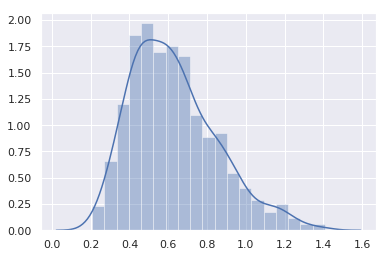

In [284]:
import seaborn as sns
sns.set()
sns.distplot(final_facets_mean)


In [288]:
gap_mesh.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [291]:
#get the facets to check on

facets_to_check = [14352,24893,11288,11342,10629,3691,19702,101,25542,21029,21167]

#get the angles data for these facets

#1) Get the facets that have these faces
facet_group_matching = dict([(f,[]) for f in facets_to_check])

for i,facet_group in enumerate(final_facets):
    for specific_face in facets_to_check:
        if specific_face in facet_group:
            facet_group_matching[specific_face].append(i)

print(facet_group_matching)

{14352: [388, 400, 468, 470], 24893: [552, 735, 736, 747], 11288: [397], 11342: [399, 472], 10629: [154, 195, 474], 3691: [9, 16, 20, 41, 76, 96], 19702: [588, 597, 751, 781], 101: [2, 3, 77, 94, 127], 25542: [803, 810], 21029: [], 21167: []}


In [294]:
total_possible_facet_groups = []
for facet_group in facet_group_matching.values():
    for facet in facet_group:
        total_possible_facet_groups.append(final_facets_mean[facet])
        #print(final_facets_mean[facet])

print(min(total_possible_facet_groups))

0.8458115497297106


In [297]:
sum(final_facets_mean > 0.8458115497297106)/len(final_facets_mean)

0.16951219512195123

In [302]:
len(final_facets_mean > adjacency_threshold)

820

In [303]:
len(final_facets)

820

In [316]:
len(np.array(final_facets)[final_facets_mean > adjacency_threshold])

139

In [318]:
#filter the final facets and output them so they can be plotted
adjacency_threshold =  0.8458115497297106
final_facets_mean_filtered = np.array(final_facets)[final_facets_mean > adjacency_threshold]
print(len(final_facets_mean_filtered))
#final_facets_mean_filtered

139


In [320]:
# download the facets list and see if the process worked:
facets_group = np.zeros(len(gap_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets_mean_filtered):
    for face in facet_group:
        facets_group[face] = i + 1 #so that you reserve the label 0 for blenders none

np.savez("./test_meshes/" + file_name[:-4] + "_facets_adj_filtered.npz",facets_group=facets_group)


len(facets_group)

25913

# How to extract facet centers

In [333]:
unique_vertices = gap_mesh.vertices[np.unique(gap_mesh.faces[final_facets_mean_filtered[0]].ravel())].astype("float")
center_coordinates = (np.mean(unique_vertices[:,0]),
                      np.mean(unique_vertices[:,1]),
                      np.mean(unique_vertices[:,2]))


center_coordinates


(TrackedArray(425930.109375),
 TrackedArray(15541.8948472),
 TrackedArray(-174161.12959559))